In [1]:
import os
import sys
import re
import math
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split

import networkx as nx
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.rdmolfiles import MolFromXYZFile
from functions.data_loader import data_loader
from classes.smiles_to_graph import MolecularGraphFromSMILES
from classes.MPNN import MPNN
from functions.compute_loss import compute_loss
from functions.evaluations import *
from functions.evaluations import evaluate_model
from functions.train import train_MPNN_model

# Load the data and couple the SMILES to the yields and remove nan's

In [2]:
yields_path = "data/compounds_yield.csv"
smiles_path = "data/compounds_smiles.csv"

df_merged = data_loader(yields_path, smiles_path)


#print("Merged DataFrame:")
#print(df_merged)


Convert the SMILES to Graphs

## Zet de SMILES om naar graphs

In [23]:
from rdkit import Chem

graphs = []
for _, row in tqdm(df_merged.iterrows(), total=len(df_merged), desc="Converting SMILES to graphs"):
    try:
        mol_graph = MolecularGraphFromSMILES(row['smiles_raw'])

        borylation_index = row['borylation_site']

        graph = mol_graph.to_pyg_data()
        graphs.append(graph)

    except Exception as e:
        print(f"Fout bij SMILES: {row['smiles_raw']}")
        print(f"  - borylation_site: {row['borylation_site']}")
        mol = Chem.MolFromSmiles(row['smiles_raw'])
        if mol:
            print(f"  - aantal atomen in RDKit mol: {mol.GetNumAtoms()}")
        else:
            print("  - RDKit kon mol niet parsen!")
        print(f"  - foutmelding: {e}")


# Eerste splitsing: 85% train+val, 15% test
train_val_graphs, test_graphs = train_test_split(
    graphs, test_size=0.15, random_state=42
)

# Tweede splitsing: 70/15 = 70/85, 0.8235 voor train
train_graphs, val_graphs = train_test_split(
    train_val_graphs, test_size=0.1765, random_state=42
)


Converting SMILES to graphs: 100%|██████████| 83/83 [00:00<00:00, 132.32it/s]


## Zet de graphs in een dataloader zodat het de GNN in kan

[Epoch 1] Train loss: 0.7807 | Site: 1.5385, Yield: 0.0228
[Epoch 2] Train loss: 0.7304 | Site: 1.4590, Yield: 0.0018
[Epoch 3] Train loss: 0.6734 | Site: 1.3462, Yield: 0.0006
[Epoch 4] Train loss: 0.5920 | Site: 1.1837, Yield: 0.0002
[Epoch 5] Train loss: 0.5086 | Site: 1.0170, Yield: 0.0002
[Epoch 6] Train loss: 0.4040 | Site: 0.8078, Yield: 0.0002
[Epoch 7] Train loss: 0.3162 | Site: 0.6323, Yield: 0.0001
[Epoch 8] Train loss: 0.2791 | Site: 0.5581, Yield: 0.0001
[Epoch 9] Train loss: 0.1872 | Site: 0.3743, Yield: 0.0000
[Epoch 10] Train loss: 0.1279 | Site: 0.2558, Yield: 0.0001
[Epoch 11] Train loss: 0.0927 | Site: 0.1854, Yield: 0.0000
[Epoch 12] Train loss: 0.0887 | Site: 0.1774, Yield: 0.0000
[Epoch 13] Train loss: 0.0772 | Site: 0.1543, Yield: 0.0001
[Epoch 14] Train loss: 0.0486 | Site: 0.0971, Yield: 0.0001
[Epoch 15] Train loss: 0.0368 | Site: 0.0736, Yield: 0.0000
[Epoch 16] Train loss: 0.0295 | Site: 0.0590, Yield: 0.0000
[Epoch 17] Train loss: 0.0252 | Site: 0.0504, Yie

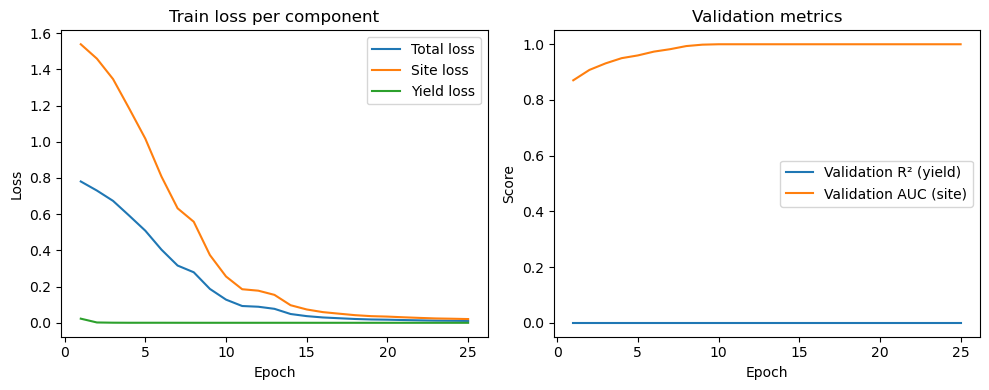

 Testresultaten:

 Borylation site prediction:
   - Accuracy      : 1.000
   - Precision     : 1.000
   - ROC AUC       : 1.000
   - Top-1 Accuracy: 0.625
   - Top-3 Accuracy: 1.000

 Yield prediction:
   - MSE           : 0.000
   - MAE           : 0.002
   - R²            : 0.000
Gemiddelde voorspelde yield: 0.32922813
Gemiddelde echte yield: 0.3303587


In [ ]:
import torch
from torch_geometric.loader import DataLoader

# Instellingen
batch_size = 8
num_epochs = 25
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Architecture MPNN
node_in_feats=train_graphs[0].x.shape[1]                # Aantal input features per node
edge_in_feats=train_graphs[0].edge_attr.shape[1]        # Aantal input features per edge
hidden_feats=32                                         # Aantal verborgen features
num_step_message_passing=3                              # Aantal stappen voor message passing
num_step_set2set=3                                      # Aantal stappen voor Set2Set
num_layer_set2set=1                                     # Aantal lagen voor Set2Set
readout_feats=1024                                      # Aantal features voor readout
activation='leaky_relu'                                 # Activatiefunctie
dropout=0.2                                            # Dropout percentage

# DataLoaders
train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)


# Initialiseer model
model = MPNN(
    node_in_feats=node_in_feats,
    edge_in_feats=edge_in_feats,
    hidden_feats=hidden_feats,
    num_step_message_passing=num_step_message_passing,
    num_step_set2set=num_step_set2set,
    num_layer_set2set=num_layer_set2set,
    readout_feats=readout_feats,
    activation=activation,
    dropout=dropout
)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop met validatie

train_total_loss_list = []
train_site_loss_list = []
train_yield_loss_list = []

val_r2_list = []
val_auc_list = []


for epoch in range(num_epochs):
    train_losses = train_MPNN_model(model, train_loader, optimizer, device)
    val_metrics, val_y_true, val_y_pred = evaluate_model(model, val_loader, device)

    print(f"[Epoch {epoch+1}] Train loss: {train_losses['total']:.4f} | "
        f"Site: {train_losses['site']:.4f}, "
        f"Yield: {train_losses['yield']:.4f}")
    train_total_loss_list.append(train_losses['total'])
    train_site_loss_list.append(train_losses['site'])
    train_yield_loss_list.append(train_losses['yield'])

    val_r2_list.append(float(val_metrics['yield_R2']))
    val_auc_list.append(val_metrics['site_AUC'])

# Evaluatie op testset na training
print("Evaluatie op testset na training:")
test_metrics, y_true, y_pred = evaluate_model(model, test_loader, device)
import matplotlib.pyplot as plt

epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(10, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_total_loss_list, label="Total loss")
plt.plot(epochs, train_site_loss_list, label="Site loss")
plt.plot(epochs, train_yield_loss_list, label="Yield loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train loss per component")
plt.legend()

# Validation metrics
plt.subplot(1, 2, 2)
plt.plot(epochs, val_r2_list, label="Validation R² (yield)")
plt.plot(epochs, val_auc_list, label="Validation AUC (site)")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation metrics")
plt.legend()

plt.tight_layout()
plt.show()


# Bereken Top-k accuracies (k=1 en k=3)
all_site_logits = []
all_site_masks = []
all_batches = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        p_borylation, _ = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)

        all_site_logits.append(torch.sigmoid(p_borylation))  # sigmoid omdat topk op probs werkt
        all_site_masks.append(batch.borylation_mask)
        all_batches.append(batch.batch)

p_borylation = torch.cat(all_site_logits)
borylation_mask = torch.cat(all_site_masks)
batch_tensor = torch.cat(all_batches)

acc_top1 = topk_accuracy(p_borylation, borylation_mask, batch_tensor, k=1)
acc_top3 = topk_accuracy(p_borylation, borylation_mask, batch_tensor, k=3)

# Print resultaten
print(" Testresultaten:")
print(f"\n Borylation site prediction:")
print(f"   - Accuracy      : {test_metrics['site_Accuracy']:.3f}")
print(f"   - Precision     : {test_metrics['site_Precision']:.3f}")
print(f"   - ROC AUC       : {test_metrics['site_AUC']:.3f}")
print(f"   - Top-1 Accuracy: {acc_top1:.3f}")
print(f"   - Top-3 Accuracy: {acc_top3:.3f}")

print(f"\n Yield prediction:")
print(f"   - MSE           : {test_metrics['yield_MSE']:.3f}")
print(f"   - MAE           : {test_metrics['yield_MAE']:.3f}")
print(f"   - R²            : {test_metrics['yield_R2']:.3f}")

print("Gemiddelde voorspelde yield:", y_pred.mean())
print("Gemiddelde echte yield:", y_true.mean())




In [9]:
import torch
from torch_geometric.loader import DataLoader
from sklearn.model_selection import KFold

def k_fold_training(graphs, model_class, k=5, num_epochs=20, batch_size=16, learning_rate=0.001, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # K-fold splits maken
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(graphs)):
        print(f"\n🔁 Fold {fold + 1}/{k}")

        train_graphs = [graphs[i] for i in train_idx]
        val_graphs = [graphs[i] for i in val_idx]

        # Dataloaders
        train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_graphs, batch_size=batch_size, shuffle=False)

        # Architectuurinstellingen
        node_in_feats = train_graphs[0].x.shape[1]
        edge_in_feats = train_graphs[0].edge_attr.shape[1]

        model = model_class(
            node_in_feats=node_in_feats,
            edge_in_feats=edge_in_feats,
            hidden_feats=128,
            num_step_message_passing=3,
            num_step_set2set=3,
            num_layer_set2set=1,
            readout_feats=1024,
            activation='leaky_relu',
            dropout=0.2
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            train_losses = train_MPNN_model(model, train_loader, optimizer, device)
            val_metrics = evaluate_model(model, val_loader, device)

            print(f"[Fold {fold+1} | Epoch {epoch+1}] Train loss: {train_losses['total']:.4f} | "
                  f"Site: {train_losses['site']:.4f}, Yield: {train_losses['yield']:.4f}")

        # Opslaan van metrics van deze fold
        fold_results.append(evaluate_model(model, val_loader, device))

    return fold_results


# === Gebruik de functie ===
# Bijvoorbeeld: k=5 fold cross-validatie over alle data

all_graphs = train_graphs + val_graphs + test_graphs  # Voeg alles samen
results = k_fold_training(all_graphs, model_class=MPNN, k=5)

# === Resultaten samenvatten ===
print("\n✅ Gemiddelde resultaten over folds:")
from collections import defaultdict
import numpy as np

avg_metrics = defaultdict(list)
for result in results:
    for key, val in result.items():
        avg_metrics[key].append(val)

for key, values in avg_metrics.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"{key:20s}: {mean_val:.4f} ± {std_val:.4f}")


🔁 Fold 1/5
[Fold 1 | Epoch 1] Train loss: 0.7296 | Site: 1.4213, Yield: 0.0378
[Fold 1 | Epoch 2] Train loss: 0.6345 | Site: 1.2663, Yield: 0.0027
[Fold 1 | Epoch 3] Train loss: 0.5730 | Site: 1.1453, Yield: 0.0008
[Fold 1 | Epoch 4] Train loss: 0.4886 | Site: 0.9768, Yield: 0.0003
[Fold 1 | Epoch 5] Train loss: 0.4589 | Site: 0.9173, Yield: 0.0006
[Fold 1 | Epoch 6] Train loss: 0.3483 | Site: 0.6964, Yield: 0.0003
[Fold 1 | Epoch 7] Train loss: 0.2516 | Site: 0.5029, Yield: 0.0002
[Fold 1 | Epoch 8] Train loss: 0.1669 | Site: 0.3337, Yield: 0.0002
[Fold 1 | Epoch 9] Train loss: 0.1036 | Site: 0.2071, Yield: 0.0001
[Fold 1 | Epoch 10] Train loss: 0.0526 | Site: 0.1051, Yield: 0.0001
[Fold 1 | Epoch 11] Train loss: 0.0321 | Site: 0.0642, Yield: 0.0000
[Fold 1 | Epoch 12] Train loss: 0.0199 | Site: 0.0398, Yield: 0.0000
[Fold 1 | Epoch 13] Train loss: 0.0128 | Site: 0.0255, Yield: 0.0000
[Fold 1 | Epoch 14] Train loss: 0.0097 | Site: 0.0194, Yield: 0.0000
[Fold 1 | Epoch 15] Train loss:

AttributeError: 'tuple' object has no attribute 'items'

New version of code used above